# Datasets and Data Objects

## Datasets

First, import yt. Simple enough. 

In [2]:
import yt

We can use the `load` function to load up one of our sample datasets. Let's load up the `IsolatedGalaxy` dataset:

In [3]:
ds = yt.load('IsolatedGalaxy/galaxy0030/galaxy0030')

yt : [INFO     ] 2017-03-02 15:05:40,838 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2017-03-02 15:05:40,840 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2017-03-02 15:05:40,842 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-03-02 15:05:40,843 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-03-02 15:05:40,845 Parameters: cosmological_simulation   = 0.0


We can see that when we loaded the dataset, it parsed some parameters and informed us of what they were. We are interested in what kinds of "fields" are in the dataset. We can list them using `ds.field_list`:

In [ ]:
ds.field_list

We also mentioned "derived" fields earlier. We can see which derived fields are available using `ds.derived_field_list`:

In [ ]:
ds.derived_field_list

Notice that the fields that are in the dataset are part of the derived field list as well--reflecting yt's philosophy on fields.

Let's now get some basic stats on this dataset, which is a grid-based Enzo dataset. We can do that with the `ds.print_stats()` method:

In [ ]:
ds.print_stats()

Let's also look at some basic properties associated with this dataset: 

In [ ]:
print(ds.domain_left_edge)
print(ds.domain_right_edge)
print(ds.domain_width)
print(ds.current_time)

These are "code" units, which are the default units of the dataset. We'd probably like to see what the units are in terms of something more "physical". We can use the `in_units()` method for that:

In [ ]:
print(ds.domain_left_edge.in_units("Mpc"))
print(ds.domain_right_edge.in_units("Mpc"))
print(ds.domain_width.in_units("Mpc"))
print(ds.current_time.in_units("Myr"))

We'll spend more time with yt's unit system later. 

## Data Objects

Data objects in yt are geometrical shapes or other collections of points/cells that can be created and then used to analyze the properties of the fields within them. 

### Spheres

Spheres, of course, are defined by a center and a radius. We can create spheres off of the dataset using the `ds.sphere()` method:

In [ ]:
sp1 = ds.sphere("max", (10.0, "kpc"))

In [ ]:
sp2 = ds.sphere(ds.domain_center, 0.25) # if radius is given without units, assumed to be "code" units

We can look up fields in the sphere in a dict-like fashion:

In [ ]:
sp2["density"]

In [ ]:
sp2["velocity_magnitude"]

### Rectangular Regions

Rectangular-shaped regions can be constructed in a couple of different ways in yt. I will be describing the "new" way to do it, which is elegant and similar to the way that NumPy arrays work. This uses the `ds.r` syntax. Creating a rectangular region containing all the data is easy:

In [ ]:
dd = ds.r[:,:,:]

We can use NumPy-like slicing to make a subset of the domain:

In [ ]:
reg1 = ds.r[0.4:0.6,0.1:0.3,0.35:0.75] # no units indicate code units

We can also use unitful numbers to construct the slices:

In [ ]:
# subset of the domain using a left and right edge
reg2 = ds.r[(490.0, "kpc"):(510.0, "kpc"),
            (490.0, "kpc"):(510.0, "kpc"),
            (490.0, "kpc"):(510.0, "kpc")]

We can access the data of the region in the same way as the sphere (showing only some of the array for brevity):

In [ ]:
reg2["velocity_x"][20:40]

So far these rectangular regions have been 1-D arrays of cells (which could be from an adaptive mesh or octree). We can use the same NumPy-like syntax to interpolate onto a 3-D grid:

In [ ]:
# subset of the domain using a left and right edge
reg3 = ds.r[(450.0, "kpc"):(550.0, "kpc"):128j,
            (450.0, "kpc"):(550.0, "kpc"):128j,
            (450.0, "kpc"):(550.0, "kpc"):128j]

In [ ]:
print(reg3["velocity_x"].shape)
print(reg3["velocity_x"][:,:,64])

### Other Data Objects

There are a number of other data objects in yt that one can use:

* 0-dimensional points
* 1-dimensional rays
* 2-dimensional slices and projections, which we'll discuss later
* 3-dimensional cylinders

### Derived Quantities

We can create useful derived quantities from data objects, which are reduction operations to yield useful scalars or  Again, there's a "new" way to do this in yt and an old way. I'm going to emphasize the new way where I am able, but there are a few examples where I'll have to use the old way. The new way again is more NumPy-like, where we can perform a number of reduction operations on fields:

#### Summation, Mean, and Standard Deviation

In [ ]:
# Taking the sum of a quantity, in this case the cell mass
sp1.sum("cell_mass")

In [ ]:
# Taking the mean of a quantity, in this case the density
sp1.mean("density")

In [ ]:
# Taking the weighted mean of a quantity, in this case the temperature weighted by the density
sp1.mean("temperature", weight="density")

In [ ]:
# Taking the standard deviation of a quantity
sp1.std("temperature", weight="density")

#### Maximum and Minimum

In [ ]:
# Find the maximum and the minimum
print(sp1.max("density"))
print(sp1.min("density"))

In [ ]:
# Difference between max and min
sp1.ptp("velocity_x")

In [ ]:
# Maximum and minimum location
print(sp1.argmax("velocity_magnitude"))
print(sp1.argmin("velocity_magnitude"))

However, you can do something even cooler with `argmin` and `argmax`: you can have it return the values of fields at this location instead of the location itself:

In [ ]:
sp1.argmax("velocity_magnitude", axis=["density", "temperature"])

There are other NumPy-like operations that we'll discuss later, in the context of slices, projections, and profiles.

#### Other Derived Quantities

yt has a number of other derived quantities without obvious NumPy-like analogues, but are relevant from the perspective of physics. These can be accessed using the `quantities` attribute of the data object (this is the old way of calculating derived quantities):

In [ ]:
# Calculating the angular momentum vector of an object
sp1.quantities.angular_momentum_vector()

In [ ]:
# Calculating the center of mass of an object
sp1.quantities.center_of_mass()

In [ ]:
# Finding the bulk velocity of an object
sp1.quantities.bulk_velocity()

## Slicing, Projecting, and Profiling

Using data objects, one can make more sophisticated reductions and selections of the data. For example, you can probably deduce from the NumPy-like syntax of `ds.r` that you can take a 2D slice:

In [7]:
slc = ds.r[0.25:0.75,0.25:0.75,0.5] # Slicing along the middle of the dataset normal to the z-axis

Which gives you a two-dimensional slice object. You can access the data in the slice in the same way as the other objects:

In [12]:
slc["velocity_y"]

YTArray([ 20310345.75621982,  20221320.30013241,  20115928.76502482, ...,
       -21960437.92266347, -21643746.58688532, -21436839.62678548]) cm/s

If you want to see a quick plot of a particular field, you can call the `slc.plot()` method and pass in the name of a field:

yt : [INFO     ] 2017-03-02 15:06:42,354 xlim = 0.250000 0.750000
yt : [INFO     ] 2017-03-02 15:06:42,356 ylim = 0.250000 0.750000
yt : [INFO     ] 2017-03-02 15:06:42,358 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2017-03-02 15:06:42,366 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



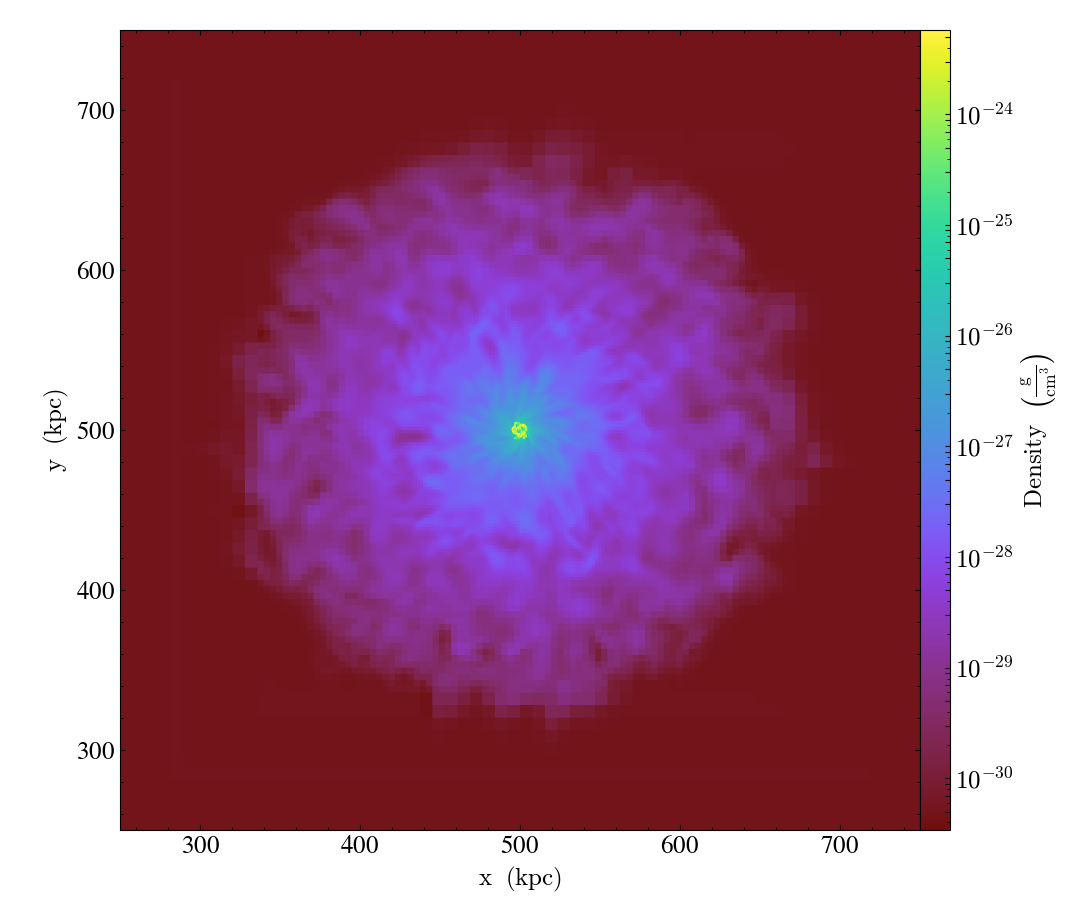

In [11]:
p = slc.plot("density")

We'll be discussing plotting more later on, so I will defer a more detailed discussion until later. 